Initial predictions:
    t_0: 2460008.4880878218 ± 10.462160090471391
    u_min: 0.32458695827035433 ± 0.06928848245005226
    t_E: 160.6167010268207 ± 96.29206517345838


c:\Users\pokey\OneDrive - The University of Manchester\Y1_onedrive\ML_Phys\MLPhysicalWorld\gaussian_process.py:22: RuntimeWarning: invalid value encountered in multiply
  5 * dist**2 /(3 * sigma_l**2)) * np.exp(-np.sqrt(5) * dist/sigma_l)


Final predictions:
    t_0: 2459983.2610471 ± 6.077826288391647
    u_min: 0.42687852329722975 ± 0.033480210696651046
    t_E: 70.93530884304919 ± 153.0557090524292


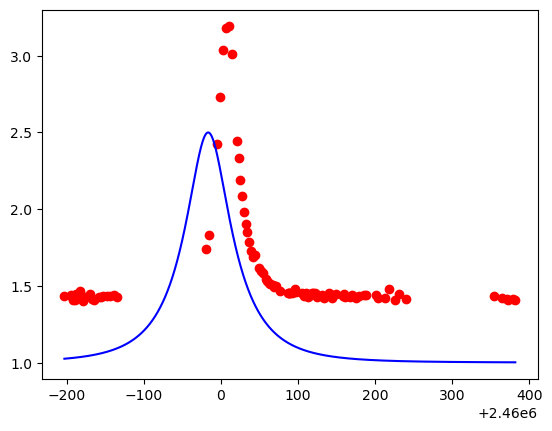

In [6]:
import numpy as np
from gaussian_process import GaussianProcess, matern52_kernel
from lensmodel import noisy_data_calc
from bayes_opt import BayesianOptimisation, expected_improvement
from samplers import gaussian_sobol
from objectives import mse
import matplotlib.pyplot as plt
from parameter_estimation import estimate_params
from lensmodel import mean_function_theta, read_and_convert, plot_final_params

df = read_and_convert("sample_data_OGLE/OGLE-2023-BLG-0063.dat", I_0=17.078)
X = df['Timestamp'].values
Y = df['Magnification'].values

observed_times, magnifications = X, Y

parameter_bounds = {
    't_E':      [0.01, 700],    # days
    't_0':      [-5, 5],        # days (placeholder, updated in the code)
    'u_min':    [0, 4]          # unitless
}

bounds = parameter_bounds

mean_function = None
sigma = 1

# Change bounds on t_0 before estimating
bounds['t_0'] = [np.min(observed_times), np.max(observed_times)]

# Estimate parameters using bootstrapping
t_E, t_E_error, t_0, t_0_error, u_min, u_min_error = estimate_params(observed_times,
                                                                        magnifications, bounds,
                                                                        mean_function)

print(
    "Initial predictions:\n"
    f"    t_0: {t_0} \u00B1 {sigma*t_0_error}\n"
    f"    u_min: {u_min} \u00B1 {sigma*u_min_error}\n"
    f"    t_E: {t_E} \u00B1 {sigma*t_E_error}"
)

# Changes bounds to take into account predictions
bounds['t_0'] = [t_0 - sigma*t_0_error, t_0 + sigma*t_0_error]
bounds['t_E'] = [t_E - sigma*t_E_error, t_E + sigma*t_E_error]
bounds['u_min'] = [u_min - sigma*u_min_error, u_min + sigma*u_min_error]

parameter_samples = []
for i in range(10):
    # Define surrogate Gaussian process
    gp = GaussianProcess(kernel=matern52_kernel, sigma_l=1, sigma_f=1)

    # Define Bayesian optimisation
    optimiser = BayesianOptimisation(surrogate=gp, acquisition=expected_improvement,
                                        objective=mse, bounds=parameter_bounds,
                                        sampler=gaussian_sobol)

    # Fit for parameters using the defined Bayesian optimiser
    optimiser.fit(observed_times, magnifications, 300)

    # Plot regret and results
    # optimiser.regret_plot()
    # optimiser.plot_best_param()

    # Append found parameters to the list of all predictions
    parameter_samples.append(optimiser.x_samples[optimiser.current_best_index])

# Calculate the best parameters and their errors as a mean and standard deviation of the 10 runs
best_parameters = np.mean(parameter_samples, axis=0)
best_parameter_errors = np.std(parameter_samples, axis=0)

print(
    "Final predictions:\n"
    f"    t_0: {best_parameters[1]} \u00B1 {best_parameter_errors[1]}\n"
    f"    u_min: {best_parameters[2]} \u00B1 {best_parameter_errors[2]}\n"
    f"    t_E: {best_parameters[0]} \u00B1 {best_parameter_errors[0]}"
)

plot_final_params(observed_times, magnifications, best_parameters)